In [1]:
# import torch
# import gc

# # Clear CUDA cache
# torch.cuda.empty_cache()
# # Clear memory
# gc.collect()

# # Restart kernel
# import IPython
# IPython.Application.instance().kernel.do_shutdown(True)

In [2]:
# Automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

In [3]:
from EDA import *
from data_preprocessing import *
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from med_seg_text_model import *
from loss import *
import torch.optim as optim
from torchsummary import summary
import functools
from text_utils import load_tokenizer, collate_fn_text 



/home/cc/.local/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
# # Define output directory for saving test plots
OUTPUT_DIR = "visualizations/test_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [5]:
#project_dir = os.path.dirname(os.path.abspath(__file__))
project_dir = os.getcwd() 
data_path = os.path.join(project_dir, "data")
print(data_path)

# EDA - image sizes, top text descriptions, sample data
#run_eda(data_path)

# Split data into train, val and test
split_data(data_path)



/home/cc/MMI_Unet_Lesion_Segmentation/data
Data split completed: 2183 training, 273 validation, 273 testing.


Data split completed: 2183 training, 273 validation, 273 testing.


In [6]:
print("Loading tokenizer...")
tokenizer = load_tokenizer()
pad_id = tokenizer.pad_token_id
vocab_size = tokenizer.vocab_size
print(f"PAD token ID: {pad_id}")
print(f"Vocabulary Size: {vocab_size}")
print("-" * 30)

# --- Optional: Define max text length if different from dataset default ---
MAX_TEXT_LEN = 50 


# In your notebook, after tokenizer = load_tokenizer()
print(f"SOS token ID: {tokenizer.bos_token_id}")
print(f"EOS token ID: {tokenizer.eos_token_id}")
print(f"PAD token ID: {tokenizer.pad_token_id}")
print(f"UNK token ID: {tokenizer.unk_token_id}") # Check UNK too
print(f"Actual Vocab Size Used for Model: {vocab_size}") # The variable passed to model

Loading tokenizer...
Added 2 special tokens.
Tokenizer Vocabulary Size: 30522
SOS token: '[SOS]', ID: 30522
EOS token: '[EOS]', ID: 30523
PAD token: '[PAD]', ID: 0
PAD token ID: 0
Vocabulary Size: 30522
------------------------------
SOS token ID: 30522
EOS token ID: 30523
PAD token ID: 0
UNK token ID: 1
Actual Vocab Size Used for Model: 30522


Added 2 special tokens.
Tokenizer Vocabulary Size: 30522
SOS token: '[SOS]', ID: 30522
EOS token: '[EOS]', ID: 30523
PAD token: '[PAD]', ID: 0
PAD token ID: 0
Vocabulary Size: 30522
------------------------------
SOS token ID: 30522
EOS token ID: 30523
PAD token ID: 0
UNK token ID: 1
Actual Vocab Size Used for Model: 30522


In [7]:
# Preprocess the data - Resize and Augmentation
train_transforms = A.Compose([
    
    A.RandomScale(scale_limit=0.1, p=0.1),  # 10% zoom
    A.Resize(224, 224),
    ToTensorV2() #convert to tensor and normalize
])

val_test_transforms = A.Compose([
    A.Resize(224, 224),
    ToTensorV2()   
])

# print("Creating datasets...")
# train_dataset = SegmentationDataset(data_path, "train", transform=train_transforms)
# val_dataset = SegmentationDataset(data_path, "val", transform=val_test_transforms) 
# test_dataset = SegmentationDataset(data_path, "test",transform=val_test_transforms) 

# print(f"Number of training samples: {len(train_dataset)}")
# print(f"Number of validation samples: {len(val_dataset)}")
# print(f"Number of testing samples: {len(test_dataset)}")

print("Creating datasets...")
train_dataset = SegmentationDataset(data_path, "train", tokenizer=tokenizer, transform=train_transforms, max_text_len=MAX_TEXT_LEN)
val_dataset = SegmentationDataset(data_path, "val", tokenizer=tokenizer, transform=val_test_transforms, max_text_len=MAX_TEXT_LEN)
test_dataset = SegmentationDataset(data_path, "test", tokenizer=tokenizer, transform=val_test_transforms, max_text_len=MAX_TEXT_LEN)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")
print("-" * 30)


Creating datasets...
Number of training samples: 2183
Number of validation samples: 273
Number of testing samples: 273
------------------------------


In [8]:
collate_with_tokenizer = functools.partial(collate_fn_text, tokenizer=tokenizer)


In [9]:
print("Creating data loaders...")
BATCH_SIZE = 8
NUM_WORKERS = 0 

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_with_tokenizer, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_with_tokenizer, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_with_tokenizer, num_workers=NUM_WORKERS)


print("Data loaders created.")
print("-" * 30)


Creating data loaders...
Data loaders created.
------------------------------


In [10]:
print("Checking one batch from train_loader...")
try:
    images_batch, masks_batch, input_ids, target_ids, target_padding_mask = next(iter(train_loader))
    print("Batch loaded successfully!")
    print(f"Images shape: {images_batch.shape}")       # Should be [B, C, H, W]
    print(f"Masks shape: {masks_batch.shape}")         # Should be [B, 1, H, W]
    print(f"Input IDs shape: {input_ids.shape}")       # Should be [B, T]
    print(f"Target IDs shape: {target_ids.shape}")     # Should be [B, T]
    print(f"Padding mask shape: {target_padding_mask.shape}") # Should be [B, T]
    print(f"Input IDs example: {input_ids[0, :15]}...") # Print first few tokens
    print(f"Target IDs example: {target_ids[0, :15]}...")
except Exception as e:
    print(f"Error loading batch: {e}")
print("-" * 30)

Checking one batch from train_loader...
Batch loaded successfully!
Images shape: torch.Size([8, 3, 224, 224])
Masks shape: torch.Size([8, 1, 224, 224])
Input IDs shape: torch.Size([8, 17])
Target IDs shape: torch.Size([8, 17])
Padding mask shape: torch.Size([8, 17])
Input IDs example: tensor([30522,  8673,  3004,  2585,    16,  2378,  4291,  3685,    16,  5500,
         2279,  2572,    18, 30523,     0])...
Target IDs example: tensor([ 8673,  3004,  2585,    16,  2378,  4291,  3685,    16,  5500,  2279,
         2572,    18, 30523,     0,     0])...
------------------------------


In [11]:
# for images, masks, text_descriptions in train_loader:
#     print(f"Image type: {type(images)}")
#     print(f"Image shape: {images.shape}")
#     print(f"Image data type: {images.dtype}") 
    
#     print(f"Text description type: {type(text_descriptions)}")

#     print(f"Mask type: {type(masks)}")
#     print(f"Mask shape: {masks.shape}")
#     print(f"Mask data type: {masks.dtype}")


#     break

In [12]:
from torchinfo import summary
from med_seg_text_model import JointSegTextUNet
import torch

#model = MMI_UNet(out_channels=1)

#summary(model)

In [13]:
# images = torch.randn(1, 3, 224, 224)  
# reports = [
# "Bilateral pulmonary infection, two infected areas, all left lung and middle right lung."
# ]

# # The model handles the text encoding internally
# segmentation_maps = model(images, reports)

In [14]:
# print(segmentation_maps)

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [16]:
from loss import *
from train import *
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


EMBED_DIM = 768 # Matching ConvNeXt F4, RATCHET used 512
NHEAD = 8
NUM_DECODER_LAYERS = 6
DIM_FEEDFORWARD = 3072 # Typically 4*EMBED_DIM, RATCHET used 2048
MAX_TEXT_SEQ_LEN = 50  #based on dataset
DROPOUT = 0.1 # RATCHET used 0.2

print("Initializing model...")
model = JointSegTextUNet(
    seg_out_channels=1, 
    vocab_size=vocab_size+2, 
    embed_dim=EMBED_DIM,
    nhead=NHEAD,
    num_decoder_layers=NUM_DECODER_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD,
    max_text_seq_len=MAX_TEXT_SEQ_LEN,
    dropout=DROPOUT,
    pad_token_id=pad_id 
).to(device) 

print("Model initialized successfully.")
# Print model summary or parameter count
# print(model)
# total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"Total trainable parameters: {total_params:,}")
print("-" * 30)




Initializing model...
Model initialized successfully.
------------------------------


Model initialized successfully.
------------------------------


In [17]:
import sys
import os
import contextlib
import matplotlib.pyplot as plt 
import torch 

# --- Configuration ---
LOG_FILE_PATH = "joint_training_log_medsegtext_cloud.txt"
TEST_OUTPUT_DIR = "visualizations/test_outputs"

os.makedirs(TEST_OUTPUT_DIR, exist_ok=True)
print(f"Test image outputs will be saved to: {TEST_OUTPUT_DIR}")
print(f"Training and testing logs will be saved to: {LOG_FILE_PATH}") 


# --- Context Manager for Logging ---
@contextlib.contextmanager
def log_stdout_to_file(filename, mode='w'): 
    original_stdout = sys.stdout
    try:
        with open(filename, mode) as log_file: # Use the mode argument
            sys.stdout = log_file
            yield # Executes the code within the 'with' block
    finally:
        sys.stdout = original_stdout # Restores normal printing


Test image outputs will be saved to: visualizations/test_outputs
Training and testing logs will be saved to: joint_training_log_medsegtext_cloud.txt


In [18]:

# --- Define Joint Training Hyperparameters ---
JOINT_EPOCHS = 50 # Adjust as needed
JOINT_LR = 1e-5
SEG_WEIGHT = 1.0
TEXT_WEIGHT = 1.0
MODEL_SAVE_PATH = "medsegtext_joint_trained_exp2.pth"

print("Starting joint training (output will be logged)...") # Prints to notebook
# --- MOD: Wrap with logger ---
with log_stdout_to_file(LOG_FILE_PATH, 'w'): # Use 'w' to overwrite/start fresh log
    print("--- Joint Training Log Start ---") # Goes to file
    # Ensure model is loaded or initialized, loaders, pad_id are defined
    train_joint_phase(
        model=model, # Pass the JointSegTextUNet instance
        train_loader=train_loader,
        val_loader=val_loader,
        pad_token_id=pad_id,
        epochs=JOINT_EPOCHS,
        learning_rate=JOINT_LR,
        seg_loss_weight=SEG_WEIGHT,
        text_loss_weight=TEXT_WEIGHT,
        model_save_path=MODEL_SAVE_PATH
    )
    print("--- Joint Training Log End ---") # Goes to file

print("Joint training finished!") # Prints to notebook

Starting joint training (output will be logged)...


/home/cc/.local/lib/python3.10/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Joint training finished!


In [19]:
print("cell running")

cell running


In [18]:
        # In the notebook cell for NLTK downloads
        import nltk
        print("Checking/downloading NLTK resources...")
        try: nltk.data.find('tokenizers/punkt')
        except: print("Downloading punkt..."); nltk.download('punkt', quiet=True)
        try: nltk.data.find('corpora/wordnet')
        except: print("Downloading wordnet..."); nltk.download('wordnet', quiet=True)
        # --- ADD THIS ---
        try:
            nltk.data.find('tokenizers/punkt_tab')
            print("'punkt_tab' already downloaded.")
        except LookupError:
            print("Downloading punkt_tab...")
            nltk.download('punkt_tab', quiet=True)
        # ---------------
        # try: nltk.data.find('????/omw-1.4') # Wordnet might require omw-1.4 too
        # except: nltk.download('omw-1.4', quiet=True)
        print("NLTK check done.")

Checking/downloading NLTK resources...
'punkt_tab' already downloaded.
NLTK check done.


'punkt_tab' already downloaded.
NLTK check done.


Calling evaluation function (output will be logged)...


--- Evaluation Log Start ---
--- Starting Evaluation (Joint Model) ---
Initializing model for inference...
Model weights loaded successfully from medsegtext_joint_trained_exp2.pth
Evaluating on 273 test samples...

--- Displaying Sample 1 ---


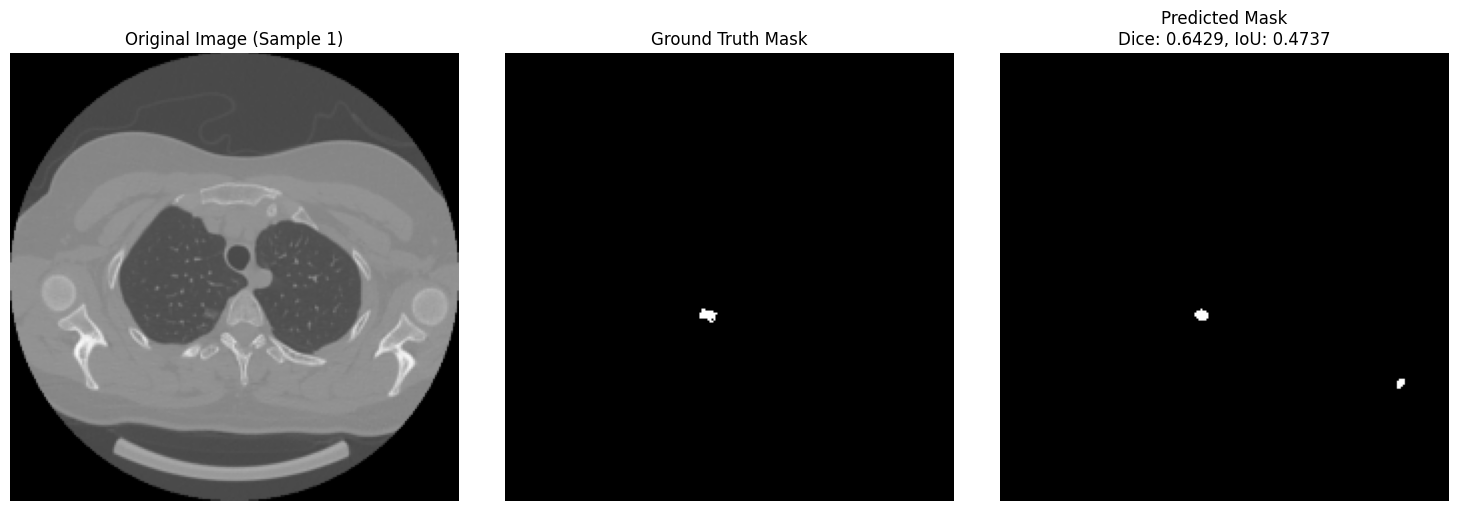

Ground Truth Text: unilateral pulmonary infection, one infected areas, middle left lung.
Predicted Text:    unilateral pulmonary infection, one infected areas, middle left lung.

--- Displaying Sample 2 ---


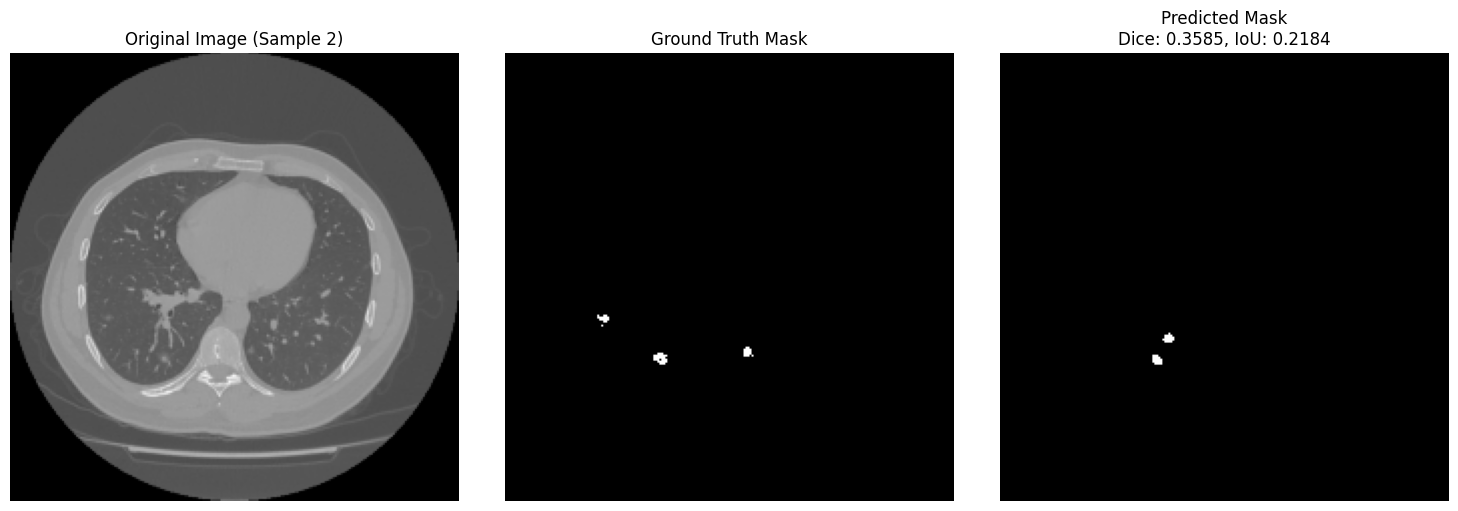

Ground Truth Text: bilateral pulmonary infection, three infected areas, middle left lung and middle right lung.
Predicted Text:    unilateral pulmonary infection, one infected areas, middle left lung.

--- Displaying Sample 3 ---


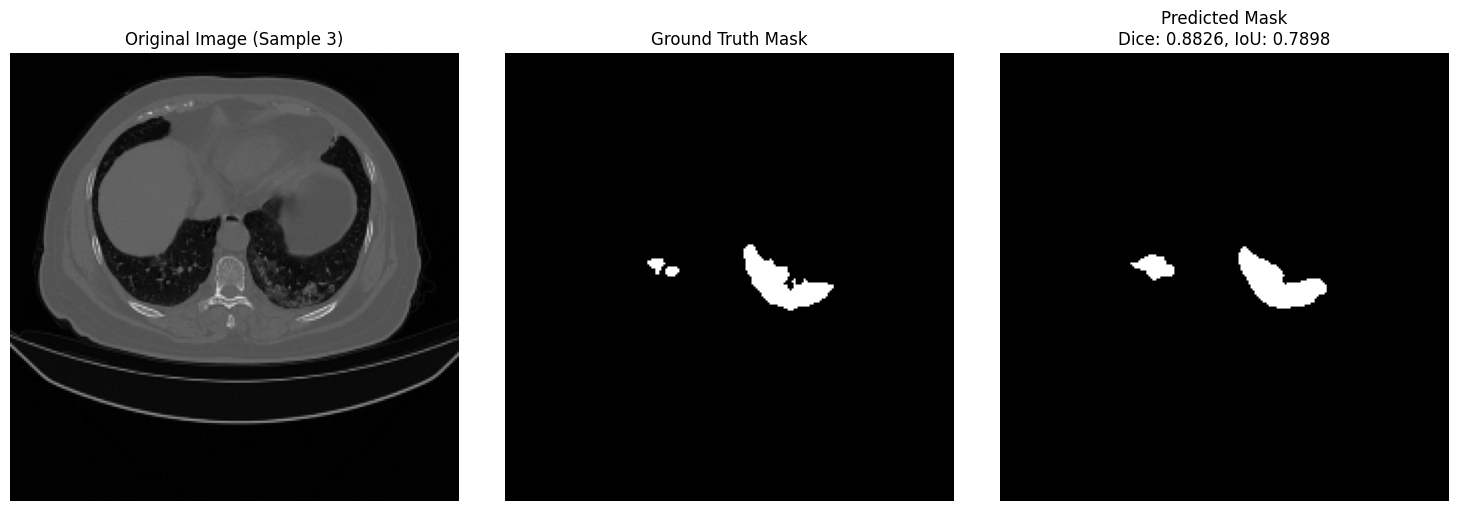

Ground Truth Text: bilateral pulmonary infection, three infected areas, middle left lung and middle right lung.
Predicted Text:    bilateral pulmonary infection, two infected areas, middle left lung and middle right lung.

--- Displaying Sample 4 ---


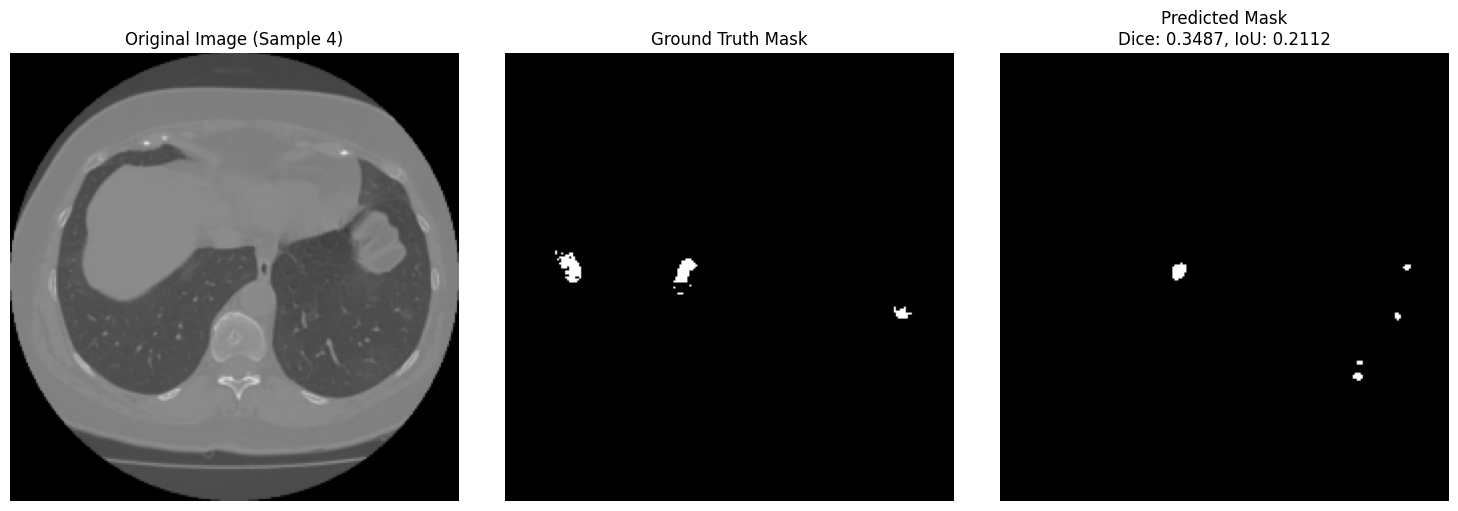

Ground Truth Text: bilateral pulmonary infection, three infected areas, middle left lung and middle right lung.
Predicted Text:    bilateral pulmonary infection, seven infected areas, middle left lung and middle right lung.

--- Displaying Sample 5 ---


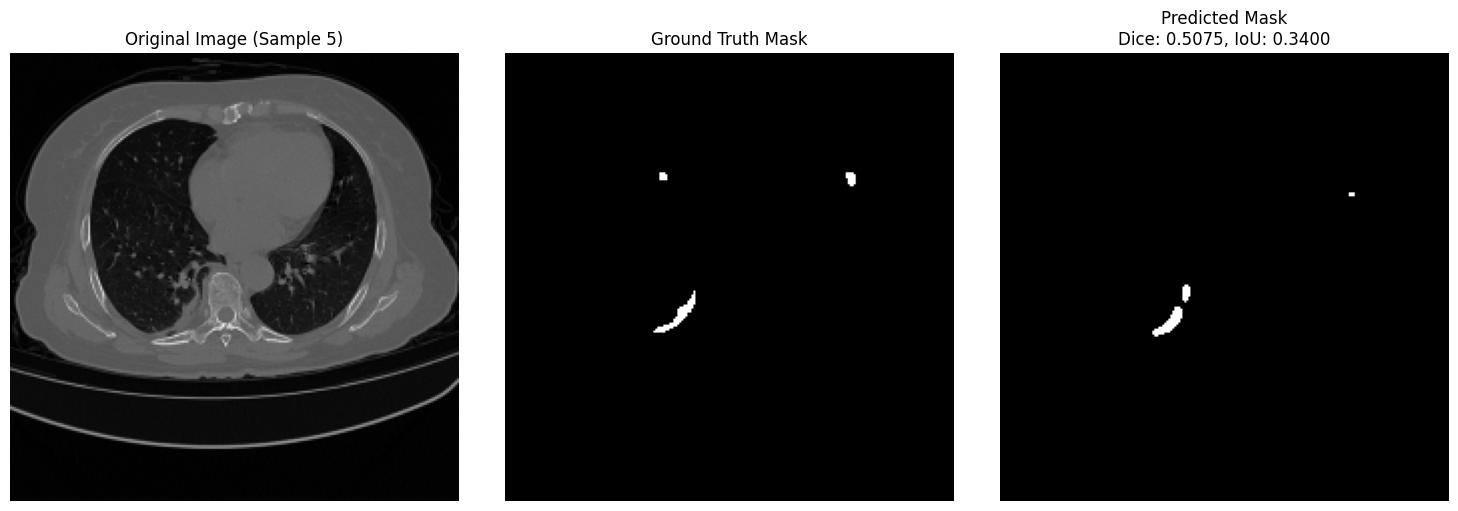

Ground Truth Text: bilateral pulmonary infection, three infected areas, upper left lung and upper right lung.
Predicted Text:    bilateral pulmonary infection, two infected areas, middle left lung and upper right lung.
  Processed 88/273 samples...
  Processed 168/273 samples...
  Processed 248/273 samples...

Finished loop (273 samples) in 38.68s.

Calculating Text Metrics (Based on 273 Valid Samples)...

Calculating Segmentation Metrics (Based on 273 Samples)...

--- Overall Evaluation Metrics ---
  BLEU-1: 0.9347
  BLEU-2: 0.9097
  BLEU-3: 0.8803
  BLEU-4: 0.8449
  METEOR: 0.9405
  ROUGE-L: 0.9292
  Avg Dice: 0.7279
  Avg IoU: 0.6147
--- Evaluation Finished ---
--- Evaluation Log End ---

--- Overall Evaluation Metrics (Notebook Output) ---
  BLEU-1: 0.9347
  BLEU-2: 0.9097
  BLEU-3: 0.8803
  BLEU-4: 0.8449
  METEOR: 0.9405
  ROUGE-L: 0.9292
  Avg Dice: 0.7279
  Avg IoU: 0.6147

Evaluation function completed successfully (details logged).


In [21]:

from text_inference import evaluate_model # Ensure it's imported

# Define Model Configuration (parameters used for training)
model_config = {
    'seg_out_channels': 1, 'vocab_size': 30524, 'embed_dim': EMBED_DIM,
    'nhead': NHEAD, 'num_decoder_layers': NUM_DECODER_LAYERS,
    'dim_feedforward': DIM_FEEDFORWARD, 'max_text_seq_len': MAX_TEXT_SEQ_LEN,
    'dropout': DROPOUT, 'pad_token_id': pad_id
}
# Use the correct jointly trained model path for this experiment
saved_model_path = "medsegtext_joint_trained_exp2.pth" # Make sure this matches the output of exp2 training

print("Calling evaluation function (output will be logged)...") # Prints to notebook
# --- MOD: Wrap the call with logger in append mode ---

print("\n\n--- Evaluation Log Start ---") # Add a separator in the log file
    # Call the Evaluation Function - Its internal prints will now go to the log file
results_dict = evaluate_model(
        model_path=saved_model_path,
        model_config=model_config,
        test_loader=test_loader,
        tokenizer=tokenizer,
        device=device,
        display_limit=5 # It will still try to display images in notebook, but prints go to file
    )
print("--- Evaluation Log End ---") # Add a footer in the log file

if results_dict is not None:
    print("\n--- Overall Evaluation Metrics (Notebook Output) ---") # Notebook header
    # Iterate through the returned dictionary and print metrics
    for metric, score in results_dict.items():
        print(f"  {metric}: {score:.4f}")
    print("\nEvaluation function completed successfully (details logged).")
else:
    # This message also goes to the notebook
    print("\nEvaluation function encountered an error (check log file).")
